In [107]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [108]:
dataset_path=r"C:\Users\igara\Ironhack Bootcamp\Bootcamp ironhack week6\Mini project computer vision\parking-lot\parking\clf-data"
empty_path=r"C:\Users\igara\Ironhack Bootcamp\Bootcamp ironhack week6\Mini project computer vision\parking-lot\parking\clf-data\empty"
not_empty_path=r"C:\Users\igara\Ironhack Bootcamp\Bootcamp ironhack week6\Mini project computer vision\parking-lot\parking\clf-data\not_empty"

Lee las direcciones de las carpetas

In [111]:
train_dir=os.path.join(dataset_path,"train")
validation_dir=os.path.join(dataset_path,"validation")
# test_dir=validation_dir=os.path.join(dataset_path,"test")

In [112]:
train_empty_dir=os.path.join(train_dir,"empty")
train_not_empty_dir=os.path.join(train_dir,"not_empty")
validation_empty_dir=os.path.join(validation_dir,"empty")
validation_not_empty_dir=os.path.join(validation_dir,"not_empty")

Crea las carpetas si todavia no existen tanto la carpeta para entrenar como las subcarpetas dentro de esta que se llaman empty y not_empty

In [113]:
# os.makedirs(os.path.join(train_dir, "empty"), exist_ok=True)
# os.makedirs(os.path.join(train_dir, "not_empty"), exist_ok=True)
# os.makedirs(os.path.join(validation_dir, "empty"), exist_ok=True)
# os.makedirs(os.path.join(validation_dir, "not_empty"), exist_ok=True)

In [115]:
from sklearn.model_selection import train_test_split

Uso test_train_split para dividir las imagenes en en train y validation para despues asignarlas a su respectiva carpeta

In [11]:
# empty_train,empty_validation=train_test_split(os.listdir(empty_path),test_size=.3,random_state=42)
# not_empty_train,not_empty_validation=train_test_split(os.listdir(not_empty_path),test_size=.3,random_state=42)

In [117]:
import shutil

In [120]:
# for file in empty_train:
#     src=os.path.join(empty_path,file)
#     dest=os.path.join(train_empty_dir,file)
#     shutil.copy(src,dest)

# for file in empty_validation:
#     src=os.path.join(empty_path,file)
#     dest=os.path.join(validation_empty_dir,file)
#     shutil.copy(src,dest)
    
# for file in not_empty_train:
#     src=os.path.join(not_empty_path,file)
#     dest=os.path.join(train_not_empty_dir,file)
#     shutil.copy(src,dest)

# for file in not_empty_validation:
#     src=os.path.join(not_empty_path,file)
#     dest=os.path.join(validation_not_empty_dir,file)
#     shutil.copy(src,dest)

Defino el batch size y el img size. Ademas extraigo las imagenes de train_dir a un dataset al igual que con validation

In [122]:
batch_size=64
img_size = (224, 224)

In [123]:
train_dataset=tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=batch_size,image_size=img_size)
validation_dataset=tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=True,batch_size=batch_size,image_size=img_size)

Found 4262 files belonging to 2 classes.
Found 1828 files belonging to 2 classes.


In [124]:
class_names = train_dataset.class_names

In [125]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [127]:
test_dataset=validation_dataset.take(val_batches//5)
validation_dataset=validation_dataset.skip(val_batches//5)

In [128]:
autotune=tf.data.AUTOTUNE

In [129]:
btrain_dataset=train_dataset.prefetch(buffer_size=autotune)
validation_dataset=validation_dataset.prefetch(buffer_size=autotune)
test_dataset=test_dataset.prefetch(buffer_size=autotune)

In [130]:
from tensorflow.keras.layers import RandomZoom, RandomContrast, RandomTranslation,RandomFlip,RandomRotation

Defino y aplico Data_augmentation ademas de definir el modelo que en este caso el que esta en uso es Resnet50

In [131]:
data_augmentation=tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),#voltea las imagenes horizontal y verticalmente que es como se pudieran encontrar lugares vacios y no 
    RandomRotation(0.01),#rotacion aleatoria de 1%

])

In [132]:
img_shape = img_size + (3,)

In [133]:
base_model = tf.keras.applications.ResNet50(input_shape=img_shape, 
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet)

In [134]:
base_model.trainable = False

In [136]:
shape=img_shape
shape

(224, 224, 3)

In [137]:
from keras import Input

Preproceso las imagenes  y defino layers para el modelo de aprendizaje

In [138]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)  # Aplicar data augmentation
x = tf.keras.applications.resnet50.preprocess_input(x)  # Preprocesar las imágenes
x = base_model(x, training=False)

In [139]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
x=global_average_layer(x)
prediction_layer=tf.keras.layers.Dense(1, activation="sigmoid")
outputs=prediction_layer(x)
model=tf.keras.Model(inputs,outputs)

In [140]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      2,049 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

se ajustan las learning rates y se compila el modelo

In [141]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [142]:
# Compile the model structure for training
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

Entrenamiento del modelo

In [143]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [144]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [145]:
initial_epochs = 50

In [146]:
import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Save training history
with open('training_history.json', 'w') as file: # open creates a file
    json.dump(history.history, file) # dump saves it as a json file

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 564s 8s/step - accuracy: 0.8917 - loss: 0.5583 - val_accuracy: 1.0000 - val_loss: 0.2127
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 573s 9s/step - accuracy: 1.0000 - loss: 0.2103 - val_accuracy: 1.0000 - val_loss: 0.2052
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 1.0000 - loss: 0.2055 - val_accuracy: 1.0000 - val_loss: 0.2038
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 1.0000 - loss: 0.2037 - val_accuracy: 1.0000 - val_loss: 0.2030
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 1.0000 - loss: 0.2028 - val_accuracy: 1.0000 - val_loss: 0.2031
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 1.0000 - loss: 0.2026 - val_accuracy: 1.0000 - val_loss: 0.2029
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 1.0000 - loss: 0.2025 - val_accuracy: 1.0000 - val_loss: 0.2023
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 1.0000 - loss: 0.2020 - val_accuracy: 1.0000 - v

In [147]:
base_model.trainable=True

In [148]:
for layer in base_model.layers[:100]: # Freeze the first 100 layers
    layer.trainable = False

In [149]:
base_learning_rate
fine_tune_learning_rate = base_learning_rate / 10 

In [150]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),  # Smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [151]:
# Same callbacks
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
fine_tune_model_checkpoint = ModelCheckpoint(filepath='fine_tuned_model.keras', monitor='val_loss', save_best_only=True)


# Define fine-tuning epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [152]:
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
    validation_data=validation_dataset,
    callbacks=[fine_tune_early_stopping, fine_tune_model_checkpoint],  # Add callbacks
    verbose=1
)

# Save fine-tuning history
with open('fine_tuning_history.json', 'w') as file:
    json.dump(history_fine.history, file)

Epoch 39/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 295s 4s/step - accuracy: 0.9851 - loss: 0.0581 - val_accuracy: 0.5007 - val_loss: 596.4938
Epoch 40/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9986 - loss: 0.0127 - val_accuracy: 0.5159 - val_loss: 15146.0820
Epoch 41/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 379s 6s/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9768 - val_loss: 0.2312
Epoch 42/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 377s 6s/step - accuracy: 1.0000 - loss: 2.4650e-04 - val_accuracy: 1.0000 - val_loss: 8.2379e-06
Epoch 43/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - accuracy: 1.0000 - loss: 5.4100e-05 - val_accuracy: 1.0000 - val_loss: 3.2960e-06
Epoch 44/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 1.0000 - loss: 1.6377e-04 - val_accuracy: 0.9993 - val_loss: 0.0014
Epoch 45/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 517s 8s/step - accuracy: 1.0000 - loss: 5.4460e-05 - val_accuracy: 1.0000 - val_loss: 5.3345e-05
Epoch 46/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 745s 11s/step - accurac

In [188]:
model = tf.keras.models.load_model('my_model_resnet50.keras')

Medidas del modelo

In [189]:
test_loss, test_accuracy = model.evaluate(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 1.0000 - loss: 4.2235e-05


In [190]:
# Load training history
with open('training_history.json', 'r') as file:
    training_history = json.load(file)

# Load fine-tuning history
with open('fine_tuning_history.json', 'r') as file:
    fine_tuning_history = json.load(file)   

In [191]:
acc = training_history['accuracy'] + fine_tuning_history['accuracy']
val_acc = training_history['val_accuracy'] + fine_tuning_history['val_accuracy']

loss = training_history['loss'] + fine_tuning_history['loss']
val_loss = training_history['val_loss'] + fine_tuning_history['val_loss']

In [202]:
normal_treshold=.5
treshold_in_my_case=0.999999

In [193]:
ground_truth = np.concatenate([labels.numpy() for _, labels in test_dataset]) 
predictions = np.concatenate([tf.where(model(X).numpy().flatten() > treshold_in_my_case).numpy() for X, _ in test_dataset]) 

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

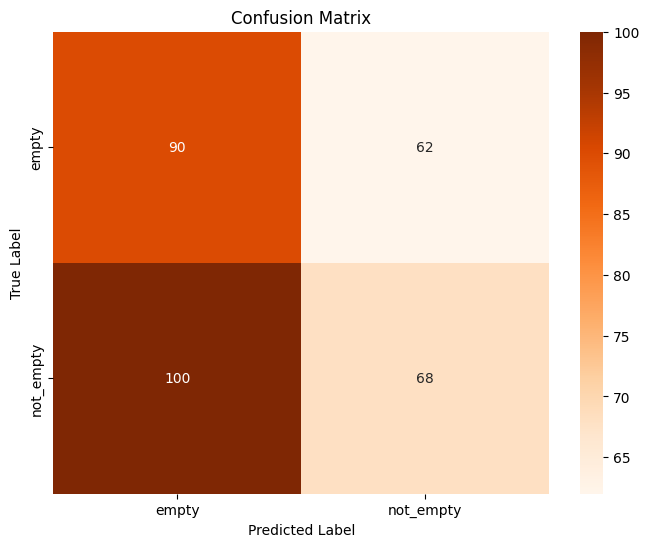

In [ ]:
# Compute confusion a
conf_matrix = confusion_matrix(ground_truth, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [196]:
from sklearn.metrics import classification_report

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(ground_truth, predictions, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       empty       0.47      0.59      0.53       152
   not_empty       0.52      0.40      0.46       168

    accuracy                           0.49       320
   macro avg       0.50      0.50      0.49       320
weighted avg       0.50      0.49      0.49       320



In [198]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

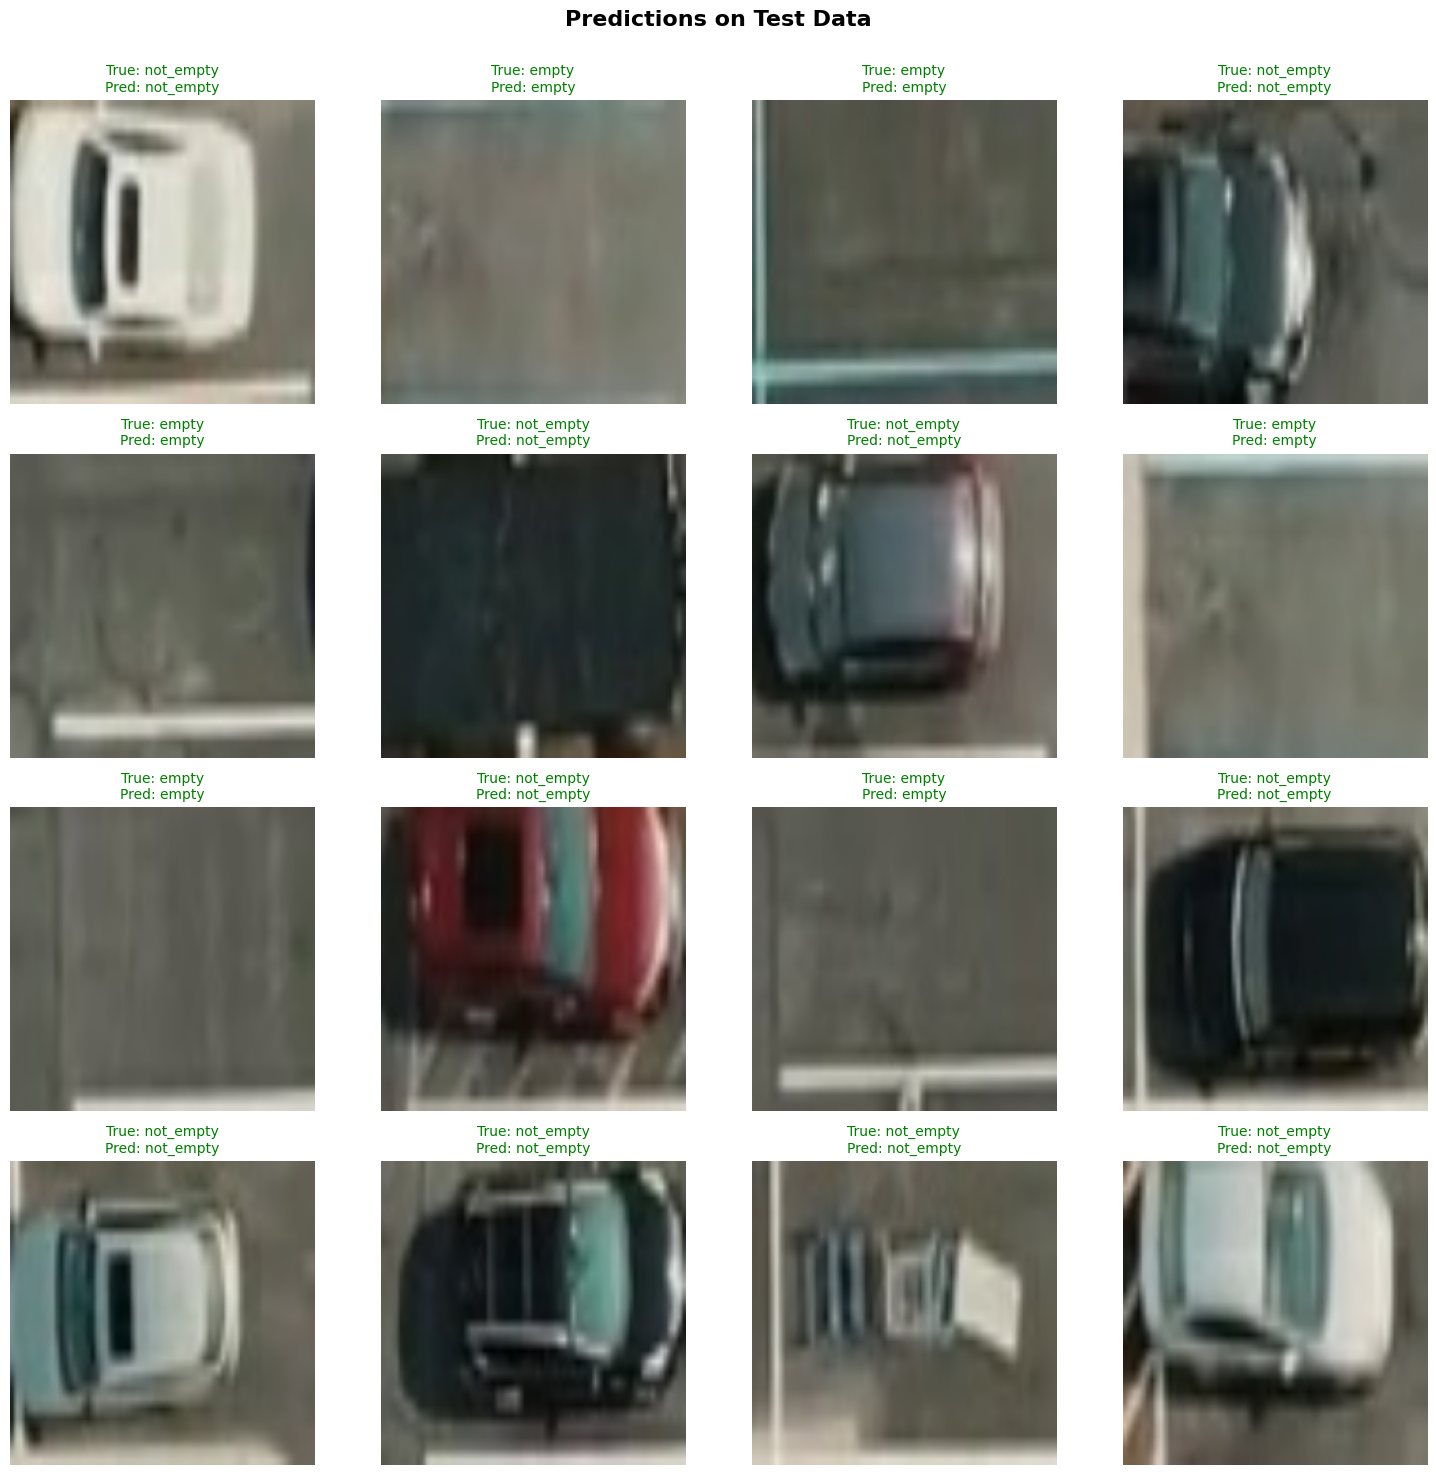

In [ ]:
# Get a batch of test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Generate predictions
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1).numpy()  # Apply threshold for binary classification

# Visualize predictions
plt.figure(figsize=(15, 15))
for i in range(16):  # Increase the number of images to 16
    ax = plt.subplot(4, 4, i + 1)  # Adjust the grid to 4x4
    plt.imshow(image_batch[i].astype("uint8"))
    true_label = label_batch[i]
    pred_label = predictions[i]
    title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    color = 'green' if true_label == pred_label else 'red'
    plt.title(title, color=color, fontsize=10)  # Make the font size smaller
    plt.axis("off")
plt.suptitle("Predictions on Test Data", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [200]:
# model.save("my_model_resnet50_2.keras")

In [201]:


# # Reload the model
# from tensorflow.keras.models import load_model
# loaded_model = load_model("my_model.keras")
